In [1829]:
import pprint
import os
import re
import pandas as pd
import numpy as np
import scipy
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

In [2851]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, Normalizer, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import AdaBoostRegressor, IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.naive_bayes import ComplementNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPRegressor

In [733]:
#set the visual style
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

In [734]:
query_dir = 'queries'

In [735]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [736]:
query_client = bigquery.Client()

In [737]:
request = queries['combined_analysis_data.sql']

In [738]:
data = query_client.query(request).to_dataframe()

In [739]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

In [740]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602 entries, 0 to 1858
Data columns (total 21 columns):
ad_id                1602 non-null int64
apt_id               855 non-null object
new_building         1602 non-null bool
num_bedrooms         1580 non-null float64
floor                1273 non-null float64
primary_size         1602 non-null float64
total_size           1546 non-null float64
price                1602 non-null float64
property_type        1602 non-null object
ownership_type       1602 non-null object
construction_year    1601 non-null float64
energy_character     753 non-null object
common_expenses      561 non-null float64
common_wealth        418 non-null float64
common_debt          536 non-null float64
time_s               1536 non-null float64
lat                  1536 non-null float64
lng                  1536 non-null float64
address              1602 non-null object
short_description    1602 non-null object
full_description     1602 non-null object
dtypes:

In [791]:
data.head()

,ad_id,apt_id,new_building,num_bedrooms,floor,primary_size,total_size,price,property_type,ownership_type,construction_year,energy_character,common_expenses,common_wealth,common_debt,time_s,lat,lng,address,short_description,full_description,energy_letter,energy_color,post_code,address_in_oslo
0,85287718,120,True,2.0,1.0,48.0,59.0,4150000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,0663,True
1,85287718,143,True,2.0,2.0,56.0,61.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,0663,True
2,85287718,183,True,2.0,5.0,51.0,59.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,0663,True
3,85287718,187,True,2.0,5.0,48.0,59.0,4350000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,0663,True
4,85287718,204,True,3.0,6.0,86.0,92.0,8495000.0,Leilighet,Eier (Selveier),2019.0,None,NaN,NaN,NaN,1262.0,59.916908,10.801887,"Innspurten 6, 06...",Hovinenga Hus C ...,Ansvarlig megler...,None,None,0663,True


In [792]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

In [793]:
def get_postcode_from_address(address):
    try:
        return re.search(r'(.*)(\d{4})(.*)', address, re.I)[2]
    except:
        return None

In [794]:
def assert_address_in_oslo(address):
    return re.match(r'.*oslo.*', address, re.I) is not None

In [795]:
data['post_code'] = data.address.apply(get_postcode_from_address)

In [796]:
data['address_in_oslo'] = data.address.apply(assert_address_in_oslo)

In [837]:
num_cols = ['primary_size', 'total_size', 'price', 'time_s', 'num_bedrooms', 'floor', 'construction_year', 'lat', 'lng']
cat_cols = ['new_building', 'energy_letter', 'energy_color', 'property_type', 'ownership_type', 'address_in_oslo']
text_cols = ['short_description', 'full_description']

In [798]:
sample_size = 5

In [799]:
data_random_one_from_new_buildings = data.groupby('ad_id').apply(lambda obj: obj.sample(sample_size)
                                                                 if len(obj) > sample_size
                                                                 else obj.sample(len(obj)))

In [800]:
num_data = data_random_one_from_new_buildings[num_cols].copy()

In [801]:
cat_data = data_random_one_from_new_buildings[cat_cols].copy()

In [802]:
for col in cat_cols:
    cat_data = cat_data.join(pd.get_dummies(cat_data[col], prefix=col, drop_first=True))
    cat_data.drop(col, axis=1, inplace=True)

In [803]:
text_data = data_random_one_from_new_buildings[text_cols].copy()

In [804]:
num_data['price_per_sq_m'] = num_data.price / num_data.primary_size

In [805]:
num_cat_data_corr = num_data.join(cat_data).corr()

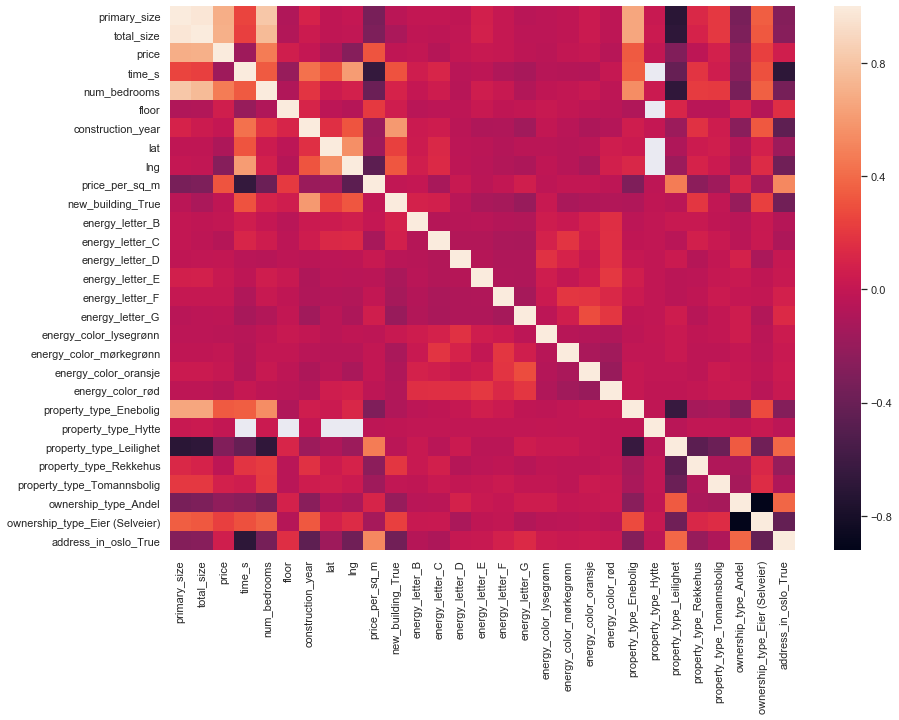

In [806]:
sns.heatmap(num_cat_data_corr)

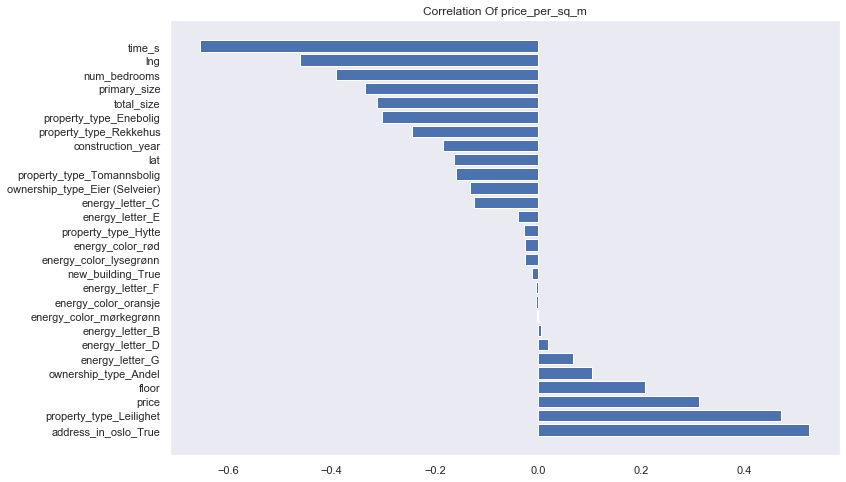

In [807]:
corr_col = 'price_per_sq_m'
to_plot = num_cat_data_corr[corr_col].drop(corr_col).sort_values(ascending=False)
f = plt.figure(figsize=(12, 8))
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title(f'Correlation Of {corr_col}')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# Predict Price With Numeric And Categorical Features

In [2490]:
model_data = num_data.join(cat_data)

In [2491]:
model_data.dropna(inplace=True)

In [2492]:
# model_data = model_data[(model_data.address_in_oslo_True==1) & (model_data.property_type_Leilighet==1)]
# model_data = model_data[model_data.total_size.isin(range(45, 95))]
# model_data = model_data[model_data.price.isin(range(int(3e6), int(8e6)))]

In [2493]:
model_data.describe()

,primary_size,total_size,price,time_s,num_bedrooms,floor,construction_year,lat,lng,price_per_sq_m,new_building_True,energy_letter_B,energy_letter_C,energy_letter_D,energy_letter_E,energy_letter_F,energy_letter_G,energy_color_lysegrønn,energy_color_mørkegrønn,energy_color_oransje,energy_color_rød,property_type_Enebolig,property_type_Hytte,property_type_Leilighet,property_type_Rekkehus,property_type_Tomannsbolig,ownership_type_Andel,ownership_type_Eier (Selveier),address_in_oslo_True
count,693.000000,693.000000,6.930000e+02,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000,693.0,693.000000,693.000000,693.000000,693.000000,693.000000,693.000000
mean,82.523810,92.976768,5.409195e+06,1936.927850,2.186147,2.911977,1979.398268,59.936497,10.835018,69530.206063,0.301587,0.046176,0.080808,0.062049,0.062049,0.099567,0.126984,0.028860,0.086580,0.138528,0.200577,0.054834,0.0,0.875902,0.036075,0.031746,0.321789,0.642136,0.620491
std,41.807722,51.846038,2.885322e+06,1155.062281,1.000713,1.755104,41.507226,0.116349,0.208572,23573.431255,0.459279,0.210018,0.272737,0.241419,0.241419,0.299638,0.333196,0.167534,0.281422,0.345703,0.400721,0.227820,0.0,0.329932,0.186612,0.175450,0.467500,0.479718,0.485615
min,14.000000,16.000000,1.514691e+06,326.000000,0.000000,1.000000,1850.000000,59.502466,10.376291,17347.783784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,56.000000,62.000000,3.500622e+06,1113.000000,2.000000,2.000000,1952.000000,59.914704,10.732694,49100.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,73.000000,80.000000,4.540060e+06,1553.000000,2.000000,2.000000,1988.000000,59.926846,10.774158,69499.151515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,94.000000,105.000000,6.407300e+06,2667.000000,3.000000,4.000000,2019.000000,59.946158,10.882372,84873.417722,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,368.000000,479.000000,2.310457e+07,7715.000000,8.000000,12.000000,2019.000000,60.334302,11.569888,156462.585034,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2494]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 693 entries, (85287718, 13) to (150469257, 1858)
Data columns (total 30 columns):
primary_size                      693 non-null float64
total_size                        693 non-null float64
price                             693 non-null float64
time_s                            693 non-null float64
num_bedrooms                      693 non-null float64
floor                             693 non-null float64
construction_year                 693 non-null float64
lat                               693 non-null float64
lng                               693 non-null float64
post_code                         693 non-null object
price_per_sq_m                    693 non-null float64
new_building_True                 693 non-null uint8
energy_letter_B                   693 non-null uint8
energy_letter_C                   693 non-null uint8
energy_letter_D                   693 non-null uint8
energy_letter_E                   693 non-null uint8

In [2495]:
model_data.columns

Index(['primary_size', 'total_size', 'price', 'time_s', 'num_bedrooms',
       'floor', 'construction_year', 'lat', 'lng', 'post_code',
       'price_per_sq_m', 'new_building_True', 'energy_letter_B',
       'energy_letter_C', 'energy_letter_D', 'energy_letter_E',
       'energy_letter_F', 'energy_letter_G', 'energy_color_lysegrønn',
       'energy_color_mørkegrønn', 'energy_color_oransje', 'energy_color_rød',
       'property_type_Enebolig', 'property_type_Hytte',
       'property_type_Leilighet', 'property_type_Rekkehus',
       'property_type_Tomannsbolig', 'ownership_type_Andel',
       'ownership_type_Eier (Selveier)', 'address_in_oslo_True'],
      dtype='object')

In [2496]:
target = 'price'
possible_targets = ['price_per_sq_m', 'price']
possible_targets.remove(target)

In [2497]:
model_data.drop(possible_targets, axis=1, inplace=True)

In [2498]:
cols = list(model_data.columns)
cols.remove(target)
cols.append(target)
model_data = model_data[cols]

In [2499]:
selected_cols = ['primary_size', 'price', 'time_s', 'num_bedrooms',
                 'floor', 'construction_year', 'lat', 'lng',
                 'property_type_Enebolig', 'property_type_Leilighet',
                 'property_type_Rekkehus', 'ownership_type_Andel',
                 'ownership_type_Eier (Selveier)', 'address_in_oslo_True']

In [2500]:
model_data = model_data[selected_cols]

In [2501]:
X = model_data.drop(target, axis=1)
y = model_data[target]

In [2502]:
x_cols = X.columns

In [2503]:
X = scipy.sparse.csr_matrix(X.values)

In [2504]:
random_seed = 42
test_size = 0.25

In [2505]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [2506]:
X_train.shape

(519, 13)

In [2507]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [2508]:
steps = []

steps.append(('scale', MaxAbsScaler()))
# steps.append(('scale', MinMaxScaler()))
steps.append(('normalize', Normalizer()))
# steps.append(('standardize', StandardScaler()))
# steps.append(('dl', KerasRegressor(build_fn=create_model, epochs=700, batch_size=700, verbose=False)))
steps.append(('ada', AdaBoostRegressor(n_estimators=100, learning_rate=0.1, loss='square', random_state=random_seed)))
# steps.append(('linear', LinearRegression()))
# steps.append(('kneighbors', KNeighborsRegressor()))
# steps.append(('bayes', ComplementNB()))
# steps.append(('mlp', MLPRegressor()))

In [2509]:
pipeline = Pipeline(steps)

In [2510]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale', MaxAbsScaler(copy=True)),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('ada',
                 AdaBoostRegressor(base_estimator=None, learning_rate=0.1,
                                   loss='square', n_estimators=100,
                                   random_state=42))],
         verbose=False)

In [2511]:
pred = pipeline.predict(X_test)

In [2512]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

In [2513]:
res = {}
for metric, name in zip([mean_absolute_error, median_absolute_error, r2_score, explained_variance_score],
                        ['mean_abs_err', 'med_abs_err', 'r2_score', 'explained_var']):
    res[name] = metric(y_test, y_pred)

In [2514]:
for key, val in res.items():
    print('Mean {}, {:.2f}'.format(key, val))

Mean mean_abs_err, 960739.41
Mean med_abs_err, 725940.91
Mean r2_score, 0.70
Mean explained_var, 0.71


In [2515]:
cross_val = cross_validate(pipeline, X, y, scoring=['neg_mean_absolute_error', 'neg_median_absolute_error', 'r2', 'explained_variance'], cv=3)
for key, val in cross_val.items():
    print('Mean {}, {:.2f}'.format(key, val.mean()))

Mean fit_time, 0.24
Mean score_time, 0.06
Mean test_neg_mean_absolute_error, -1188018.25
Mean test_neg_median_absolute_error, -928273.23
Mean test_r2, 0.67
Mean test_explained_variance, 0.70


In [2516]:
train_sizes, train_scores, test_scores = learning_curve(pipeline,
                                                        X_train,
                                                        y_train,
                                                        train_sizes = np.arange(0.1, 1.1, 0.1),
                                                        scoring='neg_mean_absolute_error',
                                                        cv=2)

In [2517]:
learning_curve_res = pd.DataFrame(columns = range(train_scores.shape[1]))
for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
    frame = pd.DataFrame(result)
    frame['size'] = train_sizes
    frame['type'] = result_type
    learning_curve_res = learning_curve_res.append(frame, ignore_index = True)

In [2518]:
learning_curve_res = learning_curve_res.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')

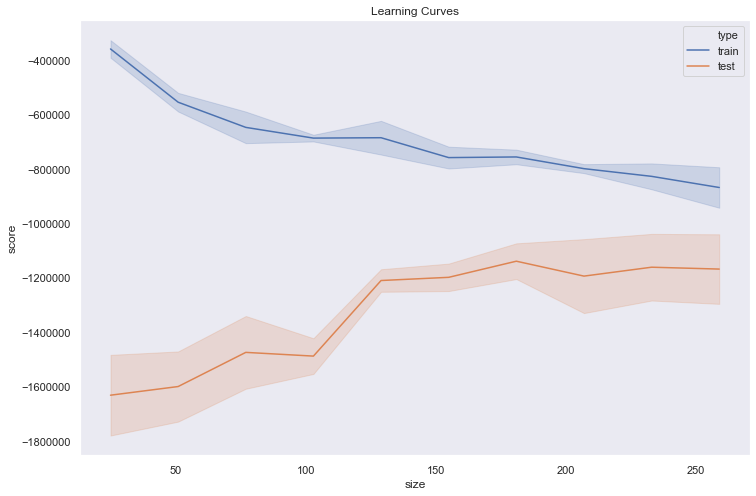

In [2519]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x = 'size', y = 'score', hue = 'type', data = learning_curve_res)

In [2520]:
feature_importances = pd.Series(pipeline.named_steps['ada'].feature_importances_, index=x_cols).sort_values(ascending=True)

In [2521]:
feature_importances

property_type_Rekkehus            0.000000
property_type_Enebolig            0.002041
ownership_type_Andel              0.003182
lat                               0.003343
floor                             0.004489
property_type_Leilighet           0.012864
construction_year                 0.020075
ownership_type_Eier (Selveier)    0.023405
address_in_oslo_True              0.025165
num_bedrooms                      0.037324
lng                               0.210396
time_s                            0.219382
primary_size                      0.438333
dtype: float64

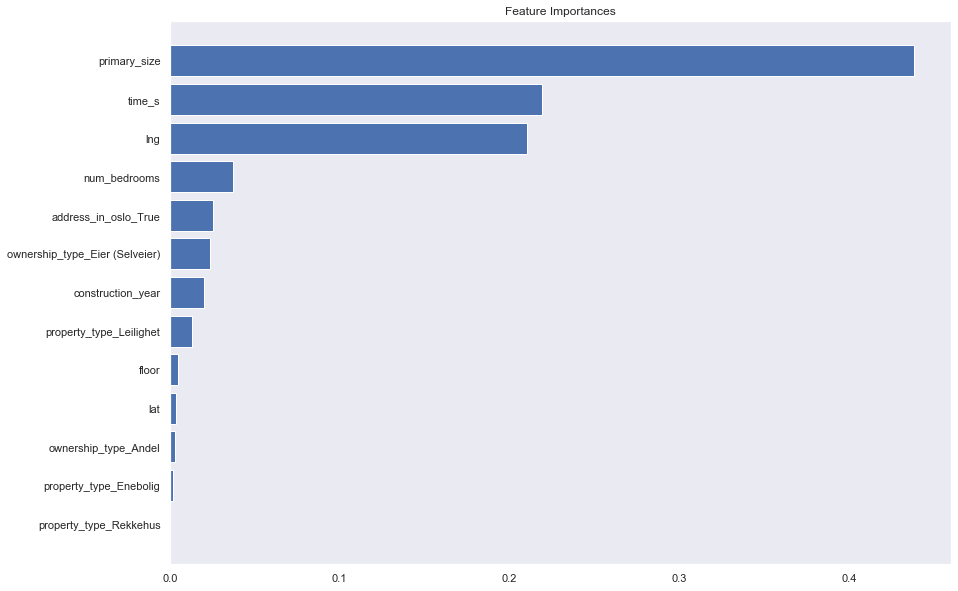

In [2522]:
plt.yticks(range(len(feature_importances)), feature_importances.index)
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances)
plt.show()

In [ ]:
prop1 = [[225, 1860, 5, 3, 1921, 59.938175, 10.967029, 1, 0, 0, 0, 1, 0]]
prop2 = [[103, 1920, 3, 3, 1978, 59.946532, 10.895096, 0, 1, 0, 1, 0, 1]]
int(pipeline.predict(prop1))
int(pipeline.predict(prop2))

In [ ]:
# scipy.sparse.hstack

# Predict Price With NLP

In [2903]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [2904]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1),
                                   # token_pattern = r'[A-z]+',
                                   # strip_accents='ascii',
                                   lowercase=True,
                                   # stop_words='english',
                                   min_df=20)

In [2905]:
y = data_random_one_from_new_buildings[data_random_one_from_new_buildings.index.isin(model_data.index)][target]

In [2906]:
y.shape

(693,)

In [2907]:
vectorized_full_desc = count_vectorizer.fit_transform(data_random_one_from_new_buildings[data_random_one_from_new_buildings.index.isin(model_data.index)].full_description)

In [2908]:
tfidf_transformer = TfidfTransformer()

In [2909]:
tfidf_full_desc = tfidf_transformer.fit_transform(vectorized_full_desc)

In [2910]:
tfidf_full_desc

<693x1593 sparse matrix of type '<class 'numpy.float64'>'
	with 101440 stored elements in Compressed Sparse Row format>

In [2911]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_full_desc, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [2912]:
estimator = KNeighborsRegressor()

In [2913]:
estimator.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [2914]:
y_pred = estimator.predict(X_test)

In [2915]:
res = {}
for metric, name in zip([mean_absolute_error, median_absolute_error, r2_score, explained_variance_score],
                        ['mean_abs_err', 'med_abs_err', 'r2_score', 'explained_var']):
    res[name] = metric(y_test, y_pred)

In [2916]:
for key, val in res.items():
    print('Mean {}, {:.2f}'.format(key, val))

Mean mean_abs_err, 1454287.52
Mean med_abs_err, 892481.40
Mean r2_score, 0.05
Mean explained_var, 0.06


In [2917]:
train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                        X_train,
                                                        y_train,
                                                        train_sizes = np.arange(0.1, 1.1, 0.1),
                                                        scoring='neg_mean_absolute_error',
                                                        cv=2)

In [2918]:
learning_curve_res = pd.DataFrame(columns = range(train_scores.shape[1]))
for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
    frame = pd.DataFrame(result)
    frame['size'] = train_sizes
    frame['type'] = result_type
    learning_curve_res = learning_curve_res.append(frame, ignore_index = True)

In [2919]:
learning_curve_res = learning_curve_res.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')

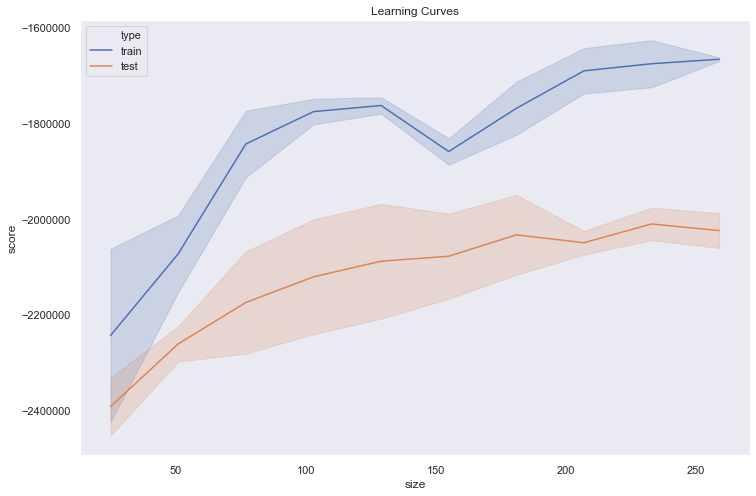

In [2920]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x = 'size', y = 'score', hue = 'type', data = learning_curve_res)

# Predict Price With All Features

In [2922]:
all_features = scipy.sparse.hstack([vectorized_full_desc, X])

In [2923]:
all_features

<693x1606 sparse matrix of type '<class 'numpy.float64'>'
	with 108047 stored elements in COOrdinate format>

In [2924]:
X_train, X_test, y_train, y_test = train_test_split(all_features, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [2925]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale', MaxAbsScaler(copy=True)),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('ada',
                 AdaBoostRegressor(base_estimator=None, learning_rate=0.1,
                                   loss='square', n_estimators=100,
                                   random_state=42))],
         verbose=False)

In [2926]:
y_pred = pipeline.predict(X_test)

In [2927]:
res = {}
for metric, name in zip([mean_absolute_error, median_absolute_error, r2_score, explained_variance_score],
                        ['mean_abs_err', 'med_abs_err', 'r2_score', 'explained_var']):
    res[name] = metric(y_test, y_pred)

In [2928]:
for key, val in res.items():
    print('Mean {}, {:.2f}'.format(key, val))

Mean mean_abs_err, 1488365.16
Mean med_abs_err, 1331828.16
Mean r2_score, 0.33
Mean explained_var, 0.38


In [2936]:
feature_importances = pd.Series(pipeline.named_steps['ada'].feature_importances_, index=list(count_vectorizer.vocabulary_.keys()) + list(x_cols)).sort_values(ascending=True)

In [2938]:
feature_importances.sort_values(ascending=False)[:20]

primary_size    0.263507
time_s          0.143537
utbyggingen     0.095745
mennesker       0.089777
kjøpe           0.051074
hos             0.028549
fordeler        0.027027
lenger          0.021337
lekker          0.013879
kontrakten      0.013454
1000            0.012588
gå              0.011577
num_bedrooms    0.011564
kilometer       0.010615
www             0.010048
arkitektur      0.009504
05              0.008521
idylliske       0.007956
m²              0.007389
høyre           0.006982
dtype: float64